In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
from google.colab import files
uploaded = files.upload()

Saving hmeq.csv to hmeq.csv


In [3]:
# Load dataset
df = pd.read_csv('hmeq.csv')
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (5960, 13)


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


Handling Missing Values (Imputation)

In [4]:
# 1. Fill Numerical columns with Median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [5]:
# 2. Fill Categorical columns with Mode
# We replace missing 'JOB' or 'REASON' with the most common entry
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [6]:
print("Missing values after cleaning:", df.isnull().sum().sum())

Missing values after cleaning: 0


Feature Encoding

In [7]:
# Convert categorical text into numeric columns (One-Hot Encoding)
df = pd.get_dummies(df, columns=['REASON', 'JOB'], drop_first=True)

df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,True,False,True,False,False,False
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,True,False,True,False,False,False
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,True,False,True,False,False,False
3,1,1500,65019.0,89235.5,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,False,False,True,False,False,False
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,True,True,False,False,False,False


Splitting the Data

In [9]:
# Define features (X) and target (y)
X = df.drop('BAD', axis=1)
y = df['BAD']

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Training and Evaluation

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       954
           1       0.86      0.63      0.73       238

    accuracy                           0.91      1192
   macro avg       0.89      0.80      0.84      1192
weighted avg       0.90      0.91      0.90      1192



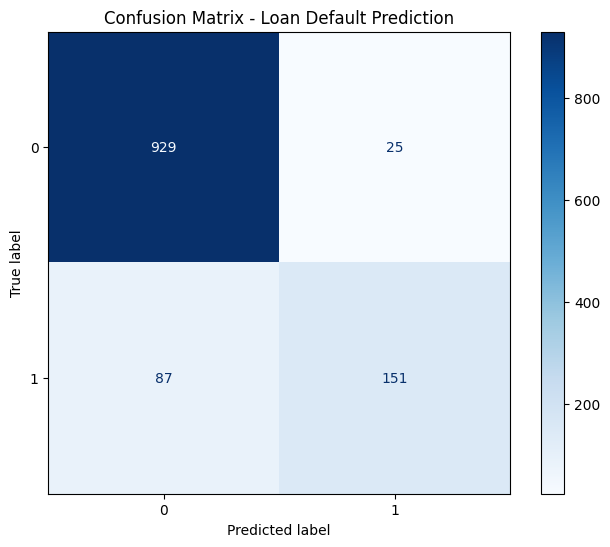

In [10]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print the Performance Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Visualize the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', ax=ax)
plt.title("Confusion Matrix - Loan Default Prediction")
plt.show()

Model Comparison

In [11]:
# Simple comparison example: Random Forest vs. Logistic Regression
from sklearn.linear_model import LogisticRegression

# 1. Random Forest (Our previous baseline)
# 2. Logistic Regression (A simpler, linear model)
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

print(f"Random Forest Accuracy: {model.score(X_test, y_test):.2f}")
print(f"Logistic Regression Accuracy: {log_model.score(X_test, y_test):.2f}")

Random Forest Accuracy: 0.91
Logistic Regression Accuracy: 0.84


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import joblib

In [17]:
#SCALING (for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Comparing Multiple Models
# We add a Decision Tree to our comparison to see which logic works best.
models = [
    ('Logistic Regression', LogisticRegression(max_iter=2000)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
]

In [19]:
results = []

print("\n--- Model Leaderboard ---")
for name, m in models:
    # We use scaled data here to be safe
    m.fit(X_train_scaled, y_train)
    preds = m.predict(X_test_scaled)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    results.append({'Model': name, 'Accuracy': acc, 'F1-Score': f1})
    print(f"{name} -> Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")



--- Model Leaderboard ---
Logistic Regression -> Accuracy: 0.8414, F1-Score: 0.4646
Decision Tree -> Accuracy: 0.8716, F1-Score: 0.6623
Random Forest -> Accuracy: 0.9060, F1-Score: 0.7295


In [20]:
# FEATURE IMPORTANCE
# Note: We use the original X_train for Random Forest
# because trees don't need scaling to show importance clearly.
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

/tmp/ipython-input-2093574117.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


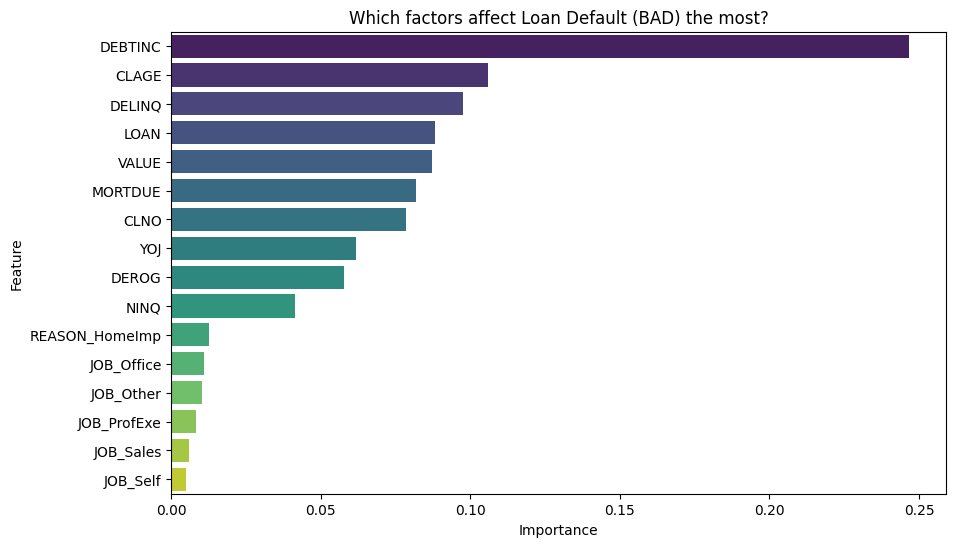

In [21]:
importances = best_model.feature_importances_
feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Which factors affect Loan Default (BAD) the most?')
plt.show()

In [22]:
# HYPERPARAMETER TUNING (Optimization)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None]
}

print("\nSearching for the best settings (Tuning)...")
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


Searching for the best settings (Tuning)...
Best Parameters: {'max_depth': 20, 'n_estimators': 100}


In [23]:
# FINAL SAVING
joblib.dump(final_model, 'hmeq_final_model.joblib')
joblib.dump(scaler, 'hmeq_scaler.joblib')
print("\nSuccess! Model and Scaler saved.")


Success! Model and Scaler saved.


HMEQ Loan Default Prediction
1. Executive Summary
The objective of this project was to develop a machine learning model to predict the probability of loan defaults using the HMEQ (Home Equity) dataset. By analyzing historical customer data, we built a system that can assist financial institutions in identifying high-risk applicants.

2. Technical Workflow
Data Preprocessing
Raw banking data is often messy. We followed these steps to prepare it:

Imputation Strategy: Missing values were handled carefully. Numerical features were filled with the Median to mitigate the impact of outliers, while categorical features were filled with the Mode.

Feature Encoding: Categorical variables such as REASON and JOB were transformed into binary vectors using One-Hot Encoding.

Feature Scaling: We applied StandardScaler to normalize numerical features. This step was crucial for algorithms like Logistic Regression to ensure faster and more accurate convergence.

Model Development & Comparison
We didn't just pick one model; we built a Leaderboard to compare performance:

Logistic Regression: Served as our linear baseline.

Decision Tree: Provided an interpretable, rule-based logic.

Random Forest: An ensemble method that combined multiple trees to achieve the highest predictive power.

Evaluation Metrics
Instead of relying solely on Accuracy, we prioritized the F1-Score.

Reason: Loan default datasets are often imbalanced. The F1-Score ensures that our model is actually successful at catching "Bad" loans (True Positives) rather than just guessing "Good" for everyone.

3. Key Findings & Insights
🔍 Feature Importance
Our Random Forest analysis revealed the top factors that influence loan defaults:

DEBTINC (Debt-to-Income Ratio): By far the most critical predictor of risk.

CLAGE (Age of Credit Line): Older, more established credit lines significantly lower the risk.

DELINQ (Number of Delinquent Lines): Past payment behavior is a strong indicator of future performance.

4. Final Conclusion & Deployment
Winning Model: The Random Forest Classifier was selected as the final model due to its superior F1-Score and robustness.

Optimization: We performed Hyperparameter Tuning via GridSearchCV to find the optimal settings for the model.

Persistence: The final model and the scaler were saved using joblib. This allows the bank to load the "trained brain" and make real-time predictions for new applicants without retraining.